**Description**: Analyzes BERT *and* GPT-2 accuracies for a given number of test
observations (200 or 500). Currently just 2 chains. Need to increase that, but it's too
slow :-(

**Estimated runtime**: ~1 hour (Multi-core isn't working on my machine. Set
`cores=4` in the `model.fit` call if it works for you.)

In [1]:
from typing import Literal

import matplotlib.pyplot as plt
import seaborn as sns

import utils

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
sns.set_theme(style="darkgrid")

# Configuration

Which number of test observations do you want to analyze?

In [3]:
num_test: Literal[200, 500] = 200

# Load data

In [4]:
accuracies_home_dir = "accuracies_from_paper"
accuracy_df = utils.load_all_accuracies(accuracies_home_dir, num_test)  # for plot
num_correct_df = utils.load_all_num_correct(accuracies_home_dir, num_test)  # for model

In [5]:
equation = "p(num_correct, num_test) ~ method + lm_type + (1|dataset/pair)"
id_vars = ["num_test", "pair", "lm_type", "dataset"]

# Plot

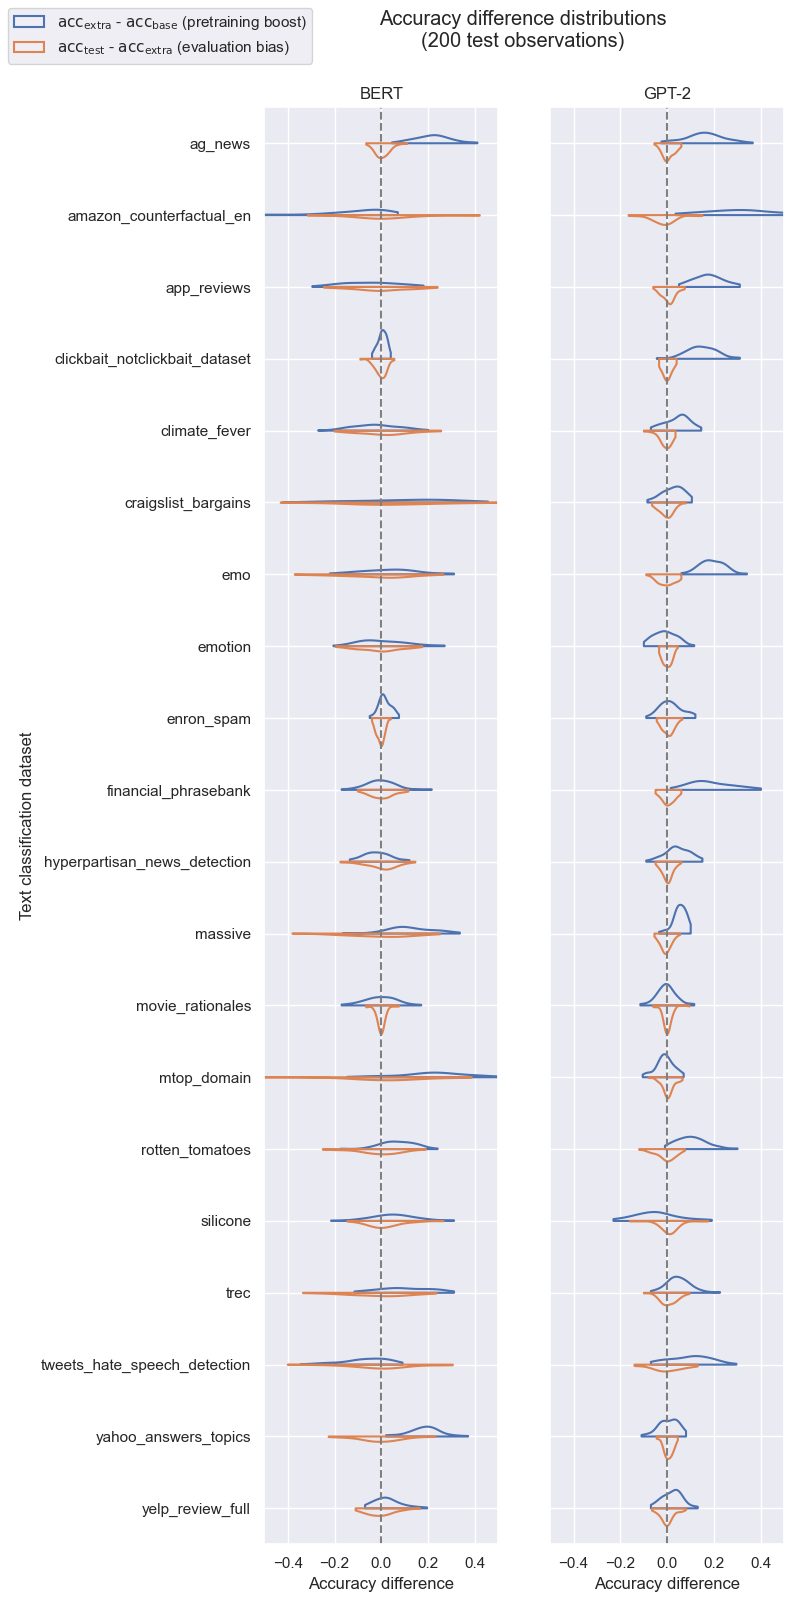

In [6]:
num_lm_types = accuracy_df["lm_type"].unique().len()
fig, axes = plt.subplots(
    nrows=1,
    ncols=accuracy_df["lm_type"].unique().len(),
    figsize=(4 * num_lm_types, 16),
)
xlim = (-0.5, 0.5)
axes: list[plt.Axes]
for subplot_idx, (lm_type, accuracy_df_lm) in enumerate(
    accuracy_df.group_by("lm_type", maintain_order=True)
):
    ax = axes[subplot_idx]
    ax.set_xlim(xlim)
    _ = utils.violin_plot(accuracy_df_lm, title=utils.lm_type_to_name[lm_type], ax=ax)
    if subplot_idx > 0:
        ax.set_yticklabels([])
        ax.set_ylabel(" ")
fig.suptitle(
    f"Accuracy difference distributions\n({num_test} test observations)", y=1, x=0.65
)
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc="upper left")
fig.tight_layout()

# Control

In [7]:
summary_control, summary_relative_control = utils.eda(
    accuracy_df, treatment="extra", control="base"
)

Overall difference:
┌──────────┬──────────┐
│ mean     ┆ std      │
╞══════════╪══════════╡
│ 0.061378 ┆ 0.104729 │
└──────────┴──────────┘
Overall difference (relative):
┌──────────┬──────────┐
│ mean     ┆ std      │
╞══════════╪══════════╡
│ 0.281803 ┆ 0.421913 │
└──────────┴──────────┘


In [8]:
summary_control

dataset,mean,std
"""ag_news""",0.1875,0.084407
"""amazon_counter…",0.111,0.259021
"""app_reviews""",0.06375,0.146638
"""clickbait_notc…",0.07535,0.086755
"""climate_fever""",0.01015,0.084821
"""craigslist_bar…",0.064,0.155706
"""emo""",0.1112,0.12452
"""emotion""",-0.0019,0.079794
"""enron_spam""",0.0152,0.038853
"""financial_phra…",0.0919,0.124334


In [9]:
summary_relative_control

dataset,mean,std
"""ag_news""",0.377502,0.21762
"""amazon_counter…",0.458375,0.944905
"""app_reviews""",0.740728,1.110947
"""clickbait_notc…",0.121475,0.148003
"""climate_fever""",0.089837,0.309847
"""craigslist_bar…",0.236656,0.429407
"""emo""",0.501643,0.529848
"""emotion""",0.047397,0.486054
"""enron_spam""",0.021421,0.056204
"""financial_phra…",0.216929,0.325152


/Users/kdubey/Envs/pretrain/lib/python3.11/site-packages/formulae/terms/call.py:108: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_string_dtype(x) or is_categorical_dtype(x) or isinstance(x, CategoricalBox):
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (4 chains in 1 job)
NUTS: [Intercept, method, lm_type, 1|dataset_sigma, 1|dataset_offset, 1|dataset:pair_sigma, 1|dataset:pair_offset]


Sampling 4 chains for 500 tune and 1_000 draw iterations (2_000 + 4_000 draws total) took 4460 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
method[extra],0.314,0.005,0.305,0.324,0.0,0.0,4911.0,2838.0,1.0


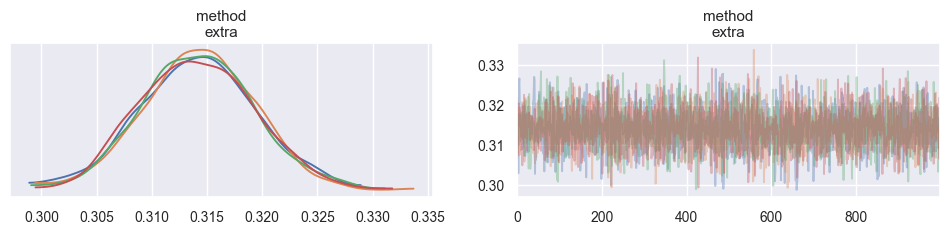

In [10]:
model_control, summary_control, az_summary_control = utils.stat_model(
    num_correct_df,
    treatment="extra",
    control="base",
    equation=equation,
    id_vars=id_vars,
)

In [11]:
print(model_control)

       Formula: p(num_correct, num_test) ~ method + lm_type + (1|dataset/pair)
        Family: binomial
          Link: p = logit
  Observations: 4000
        Priors: 
    target = p
        Common-level effects
            Intercept ~ Normal(mu: 0.0, sigma: 1.0)
            method ~ Normal(mu: 0.0, sigma: 1.0)
            lm_type ~ Normal(mu: 0.0, sigma: 5.0)
        
        Group-level effects
            1|dataset ~ Normal(mu: 0.0, sigma: HalfNormal(sigma: 1.0))
            1|dataset:pair ~ Normal(mu: 0.0, sigma: HalfNormal(sigma: 1.0))
------
* To see a plot of the priors call the .plot_priors() method.
* To see a summary or plot of the posterior pass the object returned by .fit() to az.summary() or az.plot_trace()


# Treatment

In [12]:
summary_bias, summary_relative_bias = utils.eda(
    accuracy_df, treatment="test", control="extra"
)

Overall difference:
┌──────────┬─────────┐
│ mean     ┆ std     │
╞══════════╪═════════╡
│ 0.002317 ┆ 0.07288 │
└──────────┴─────────┘
Overall difference (relative):
┌──────────┬──────────┐
│ mean     ┆ std      │
╞══════════╪══════════╡
│ 0.033694 ┆ 0.246032 │
└──────────┴──────────┘


In [13]:
summary_bias

dataset,mean,std
"""ag_news""",0.00565,0.028838
"""amazon_counter…",0.00615,0.12268
"""app_reviews""",0.0051,0.085602
"""clickbait_notc…",-0.00165,0.022564
"""climate_fever""",0.00295,0.078203
"""craigslist_bar…",0.0201,0.152347
"""emo""",-0.01185,0.104791
"""emotion""",-0.00345,0.062137
"""enron_spam""",0.00035,0.020929
"""financial_phra…",0.00415,0.041219


In [14]:
summary_relative_bias

dataset,mean,std
"""ag_news""",0.009477,0.04188
"""amazon_counter…",0.034038,0.24227
"""app_reviews""",0.055319,0.344912
"""clickbait_notc…",-0.00185,0.027262
"""climate_fever""",0.048042,0.331628
"""craigslist_bar…",0.119308,0.507278
"""emo""",0.002637,0.234181
"""emotion""",0.036093,0.31533
"""enron_spam""",0.001715,0.028466
"""financial_phra…",0.007566,0.058761


/Users/kdubey/Envs/pretrain/lib/python3.11/site-packages/formulae/terms/call.py:108: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_string_dtype(x) or is_categorical_dtype(x) or isinstance(x, CategoricalBox):
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (4 chains in 1 job)
NUTS: [Intercept, method, lm_type, 1|dataset_sigma, 1|dataset_offset, 1|dataset:pair_sigma, 1|dataset:pair_offset]


Sampling 4 chains for 500 tune and 1_000 draw iterations (2_000 + 4_000 draws total) took 4273 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
method[test],0.012,0.005,0.002,0.021,0.0,0.0,5824.0,3087.0,1.0


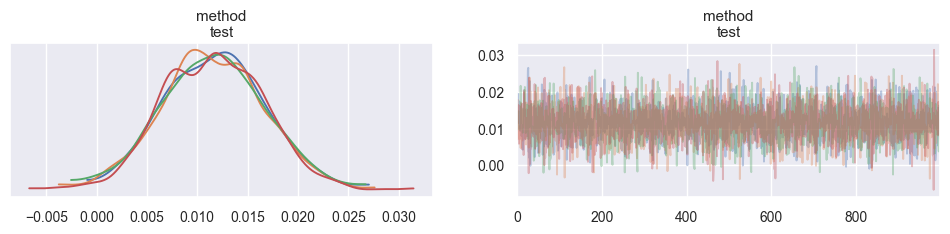

In [15]:
model_bias, summary_bias, az_summary_bias = utils.stat_model(
    num_correct_df,
    treatment="test",
    control="extra",
    equation=equation,
    id_vars=id_vars,
)

In [16]:
print(model_bias)

       Formula: p(num_correct, num_test) ~ method + lm_type + (1|dataset/pair)
        Family: binomial
          Link: p = logit
  Observations: 4000
        Priors: 
    target = p
        Common-level effects
            Intercept ~ Normal(mu: 0.0, sigma: 1.0)
            method ~ Normal(mu: 0.0, sigma: 1.0)
            lm_type ~ Normal(mu: 0.0, sigma: 5.0)
        
        Group-level effects
            1|dataset ~ Normal(mu: 0.0, sigma: HalfNormal(sigma: 1.0))
            1|dataset:pair ~ Normal(mu: 0.0, sigma: HalfNormal(sigma: 1.0))
------
* To see a plot of the priors call the .plot_priors() method.
* To see a summary or plot of the posterior pass the object returned by .fit() to az.summary() or az.plot_trace()


In [17]:
summary_bias.to_netcdf(filename=f"main_{num_test}_bias.nc")
summary_control.to_netcdf(filename=f"main_{num_test}_control.nc")

'main_200_control.nc'